Try the following: 
- For imputation, shuffle tables in both directions (df1 constant and shuffle df2 + vice versa)
- Plot both histograms on the same chart with some transparency for each
- Plot same true norm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import git

np.random.seed(19680801)
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [2]:
# Credit: https://stackoverflow.com/questions/5040797/shuffling-numpy-array-along-a-given-axis
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

In [3]:
encode_supp = pd.read_csv(os.path.join(git_root, "output", "encode_supp_percent_by_region.csv"), index_col=0)
encode = pd.read_csv(os.path.join(git_root, "output", "encode_percent_by_region.csv"), index_col=0)
encode_downsampled = pd.read_csv(os.path.join(git_root, "output", "encode_downsampled_percent_by_region.csv"), index_col=0)
spidr = pd.read_csv(os.path.join(git_root, "output", "spidr_percent_by_region.csv"), index_col=0)

In [4]:
def shuffle_impute(df1, df2, samples=1000):
    # Find true difference
    true_diff = np.matrix.flatten(df1.to_numpy() - df2.to_numpy())
    true_norm = np.linalg.norm(true_diff, ord=2)

    # create list to store distribution
    fix1_shuffle2 = []
    fix2_shuffle1 = []
    df1_true = np.matrix.flatten(df1.to_numpy())
    df2_true = np.matrix.flatten(df2.to_numpy())
    
    for _ in range(samples):
        # Store copies of dataframes to avoid inplace operations
        df1_np = df1.to_numpy()
        df2_np = df2.to_numpy()
        
        # Shuffle and calculate norm
        df2_shuffled = shuffle_along_axis(df2_np, axis=1)
        df2_shuffled_array = np.matrix.flatten(df2_shuffled)
        df2_shuffled_norm = np.linalg.norm(df1_true - df2_shuffled_array)
        fix1_shuffle2.append(df2_shuffled_norm)
        
        # Shuffle and calculate norm
        df1_shuffled = shuffle_along_axis(df1_np, axis=1)
        df1_shuffled_array = np.matrix.flatten(df1_shuffled)
        df1_shuffled_norm = np.linalg.norm(df2_true - df1_shuffled_array)
        fix2_shuffle1.append(df1_shuffled_norm)

    return true_norm, fix1_shuffle2, fix2_shuffle1

In [5]:
def imputation_hist(distribution1, distribution2, true_val, dist1_name, dist2_name, name, ax):
    ax.hist(distribution1, alpha=0.5, bins=40, color='blue', label=f"Fix {dist1_name} | Shuffle {dist2_name}")
    ax.hist(distribution2, alpha=0.5, bins=40, color='red', label=f"Fix {dist2_name} | Shuffle {dist1_name}")
    ax.axvline(true_val, color='k', linestyle='dashed', linewidth=1, label='Observed L2 Norm')
    
    ax.set_ylabel("L2 Norm")
    ax.set_title(name)
    ax.legend(loc='center')

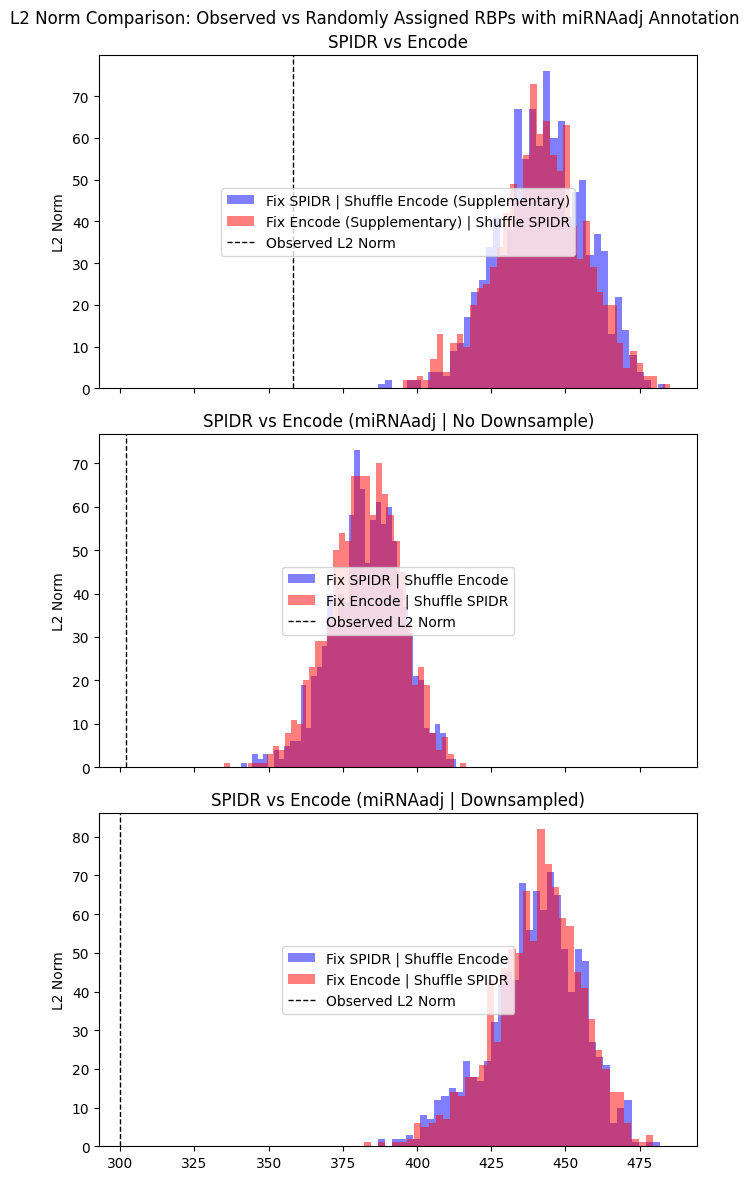

In [8]:
fig, ax = plt.subplots(3,1, sharex=True)
scale = 1.5
fig.set_size_inches(4.5 * scale, 8 * scale)

true_norm, dist1, dist2 = shuffle_impute(spidr, encode_supp)
imputation_hist(dist1, dist2, true_norm, "SPIDR", "Encode (Supplementary)", name="SPIDR vs Encode", ax=ax[0])

true_norm, dist1, dist2 = shuffle_impute(spidr, encode)
imputation_hist(dist1, dist2, true_norm, "SPIDR", "Encode", name="SPIDR vs Encode (miRNAadj | No Downsample)", ax=ax[1])

true_norm, dist1, dist2 = shuffle_impute(spidr, encode_downsampled)
imputation_hist(dist1, dist2, true_norm, "SPIDR", "Encode", name="SPIDR vs Encode (miRNAadj | Downsampled)", ax=ax[2])

fig.suptitle("L2 Norm Comparison: Observed vs Randomly Assigned RBPs with miRNAadj Annotation")
fig.tight_layout()

In [9]:
fig.savefig(os.path.join(git_root, "figures", "l2-shuffle-impute-with-miRNAadj.png"))